# Implementation of VGG-16 Pre-Trained model.

### Downloading dataset from kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shreyapmaher/fruits-dataset-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fruits-dataset-images


### Libraries

In [ ]:
!pip install split_folders

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import os
import splitfolders


2025-10-16 06:30:59.896665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760596260.081999      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760596260.136038      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# path = "/root/.cache/kagglehub/datasets/shreyapmaher/fruits-dataset-images/versions/1/images"
path_in_kaggle = "/kaggle/input/fruits-dataset-images/images"
# show total files and classes
dataset = tf.keras.utils.image_dataset_from_directory(
    # path,
    path_in_kaggle,
    image_size=(64, 64),
    batch_size=32,
    label_mode="categorical"
)

Found 360 files belonging to 9 classes.


I0000 00:00:1760596271.743212      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
# input_folder = path
input_folder = path_in_kaggle

output_folder = '/content/fruits'  # where to save split data

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2))


Copying files: 360 files [00:03, 92.47 files/s] 


In [ ]:
# To show train and test folder's data
!ls /content/fruits/train
!ls /content/fruits/val # val is used as test


'apple fruit'	'chickoo fruit'  'mango fruit'
'banana fruit'	'grapes fruit'	 'orange fruit'
'cherry fruit'	'kiwi fruit'	 'strawberry fruit'
'apple fruit'	'chickoo fruit'  'mango fruit'
'banana fruit'	'grapes fruit'	 'orange fruit'
'cherry fruit'	'kiwi fruit'	 'strawberry fruit'


## Load Dataset

In [ ]:
train_dir = '/content/fruits/train'
test_dir = '/content/fruits/val'

# Data Augmentation for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 287 images belonging to 9 classes.
Found 72 images belonging to 9 classes.


## Load Pre-trained Model (VGG16)

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze Base Layers
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Custom Layers

In [ ]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(train_data.num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

## Compile the Model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## Train the Model

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1760596345.204837     111 service.cc:148] XLA service 0x792b2c00dc40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760596345.205383     111 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760596345.555149     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/9 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1953 - loss: 2.6720 

I0000 00:00:1760596353.987554     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1523 - loss: 2.5485 - val_accuracy: 0.3056 - val_loss: 1.8420
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2753 - loss: 1.9399 - val_accuracy: 0.5000 - val_loss: 1.5069
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5705 - loss: 1.4486 - val_accuracy: 0.5833 - val_loss: 1.2810
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6176 - loss: 1.1764 - val_accuracy: 0.6528 - val_loss: 1.1358
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6190 - loss: 1.1178 - val_accuracy: 0.7083 - val_loss: 0.9900
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6947 - loss: 0.9581 - val_accuracy: 0.6944 - val_loss: 0.9232
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7256 - loss: 0.8719 - val_accuracy: 0.7361 - val_loss: 0.8718
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7375 - loss: 0.8459 - val_accuracy: 0.6944 - val_loss: 0.8416
Epoch 9/10
9/9 ━━━━

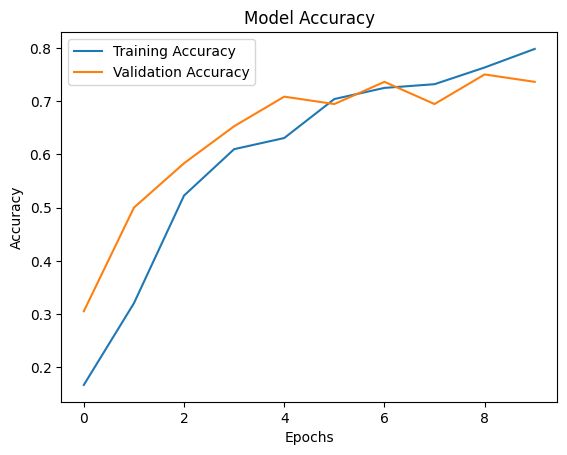

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
